In [16]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image, display_html, display, Math, HTML;

# Learning From Data

We are now beginnging to discuss how to learn from data.

The idea of learning from data is one of the most important shifts in thinking about computing to come about in the past 50 years.

Consider the commonly heard phrase:

>"Computers can only do what we tell them to do."

or

>"Computers can not create anything new.  They can only do what we already know how to do."

This line of argument goes back to Lady Ada Lovelace, often credited as the first programmer.

Working with Charles Babbage, she wrote about the Analytical Engine:

>The Analytical Engine has no pretensions whatever to originate anything. It can do whatever we know how to order it to perform. It can follow analysis; but it has no power of anticipating any analytical relations or truths.

Ada Augusta Lovelace, Commentary on "Sketch of the Analytical Engine" (1843)

However, it is clear that this viewpoint is entirely __wrong.__

All around us today, computers solve problems that humans do not know how to solve.

Computers routinely beat the world's experts in games of chess, go, etc.    They perform tasks such as facial recognition, speech synthesis, automatic language translation, and so forth.   

In each case, the programmers who wrote the programs may not themselves know how to perform these tasks.

Instead, those programmers have written programs that __learn from data.__

However, the best methods for learning from data have taken decades to develop.  

So we will spend some time now talking about the general problem of learning from data.

## The Supervised Learning Problem

The supervised learning problem in general is:
    
You are given some example data, which we'll think of abstractly as tuples $\{(\mathbf{x}_i, y_i)\,|\,i = 1,\dots,N\}$.  

Your goal is to learn a rule that allows you to predict $y_j$ for some $\mathbf{x}_j$ that is not in the example data you were given.

Typically $\mathbf{x}$ is a vector.

We use the term "features" to refer to the components of $\mathbf{x}$.

The collection $\{(\mathbf{x}_i, y_i)\,|\,i = 1,\dots,N\}$ is called the __training data.__

If $y$ is a discrete value (a label, for example) then the problem is called __classification.__

For example, in image recognition, the features $\mathbf{x}$ could be a vector that represents the pixels of the image, and $y$ could be a label such as "tiger," "tree," etc.

If $y$ is a continuous (numeric) value, then the problem is called __regression.__ 

For example, in predicting housing prices, the features $\mathbf{x}$ could be a vector containing lot size, square footage, number of bathrooms, etc., and $y$ could be the sale price of the house.

In the regression case, you will usually be satisfied if your prediction is __close__ to the true $y$ (it doesn't have to be exact to be useful).

What do we have to assume to make this problem tractable?

We assume two things:
1. There is a set of functions ("rules") that could be used to predict $y_i$ from $\mathbf{x}_i$.   This allows us to turn the learning problem into one that searches through this set for the "right" function.   However, this set is probably __very__ large!

2. The rule for predicting $y_i$ from $\mathbf{x}_i$ is the same as the rule for predicting $y_j$ from the new item $\mathbf{x}_j$. Speaking probabilistically, we say that $(\mathbf{x}_i, y_i)$ and $(\mathbf{x}_j, y_j)$ are drawn from the __same distribution.__

## A Toy Example

```{note}
The following is based on _Pattern Recognition and Machine Learning,_ Christopher Bishop (2006), Section 1.1.
```

In order to explore these ideas a bit, we'll use a toy example: a regression problem.

This is a very artificial example, but it will expose some important wrinkles in the supervised learning problem.

We will consider polynomial curve fitting.

Suppose we are given a training set comprising $N$ observations of a scalar value $x_i$, which we'll collect into the vector $\mathbf{x}$.  

For each $x_i$ we have a corresponding numeric value $y_i$, and these form $\mathbf{y}$.

Here is a plot of the 10 training points:

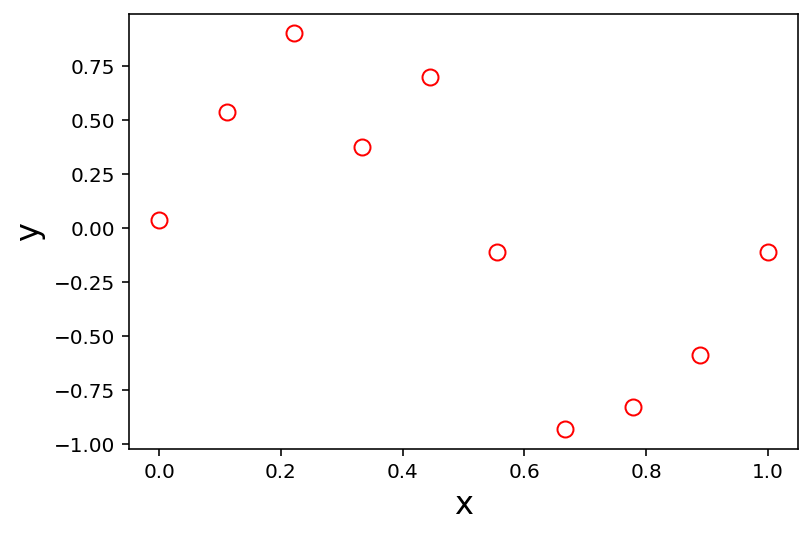

In [17]:
N = 10
x = np.linspace(0, 1, N)
from numpy.random import default_rng
y = np.sin(2 * np.pi * x) + default_rng(2).normal(size = N, scale = 0.20)
# plt.figure(figsize = (3, 2))
plt.plot(x, y, 'ro', markersize = 8, fillstyle = 'none')
plt.xlabel('x', size = 16)
plt.ylabel('y', size = 16);

The way we generated these points was to take $\mathbf{x}$ as equal spaced points on the range 0 to 1,

and for each $x_i$, we take $y_i = \sin(2\pi x_i)$ __plus__ a sample of a Gaussian random variable.

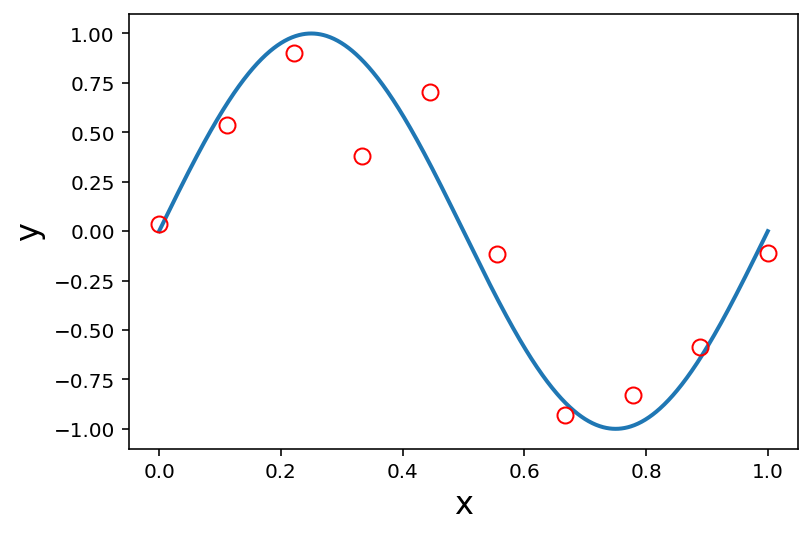

In [18]:
cx = np.linspace(0, 1, 1000)
cy = np.sin(2 * np.pi * cx)
plt.plot(cx, cy, lw = 2)
plt.plot(x, y, 'ro', markersize = 8, fillstyle = 'none')
plt.xlabel('x', size = 16)
plt.ylabel('y', size = 16);

Many data sets are like this!  

In many cases, there is some component of $y$ that depends on $x$, and some component that we treat as random, called "noise."

The "noise" component is typically not __really__ random, but rather depends on features that we cannot see.

(Remember, probability is useful for exactly this case.)

Now for this toy example, we "happen" to know that the __correct__ rule to use for prediction is:
    
$$ y = \sin(2\pi x) $$

and the Gaussian random addition does not depend on $x$ so we cannot hope to predict it.

OK, let's learn from this data.

We will consider a simple approach based on curve fitting.

The class of models we will consider are polynomials.   They are of the form:

$$ y(x, \mathbf{w}) = w_0 + w_1 x + w_2 x^2 + \dots + w_k x^k = \sum_{j = 0}^k w_jx^j $$

where $k$ is the _order_ of the polynomial.

If we are given some $k$, then what we want to learn are the $w_i$s, that is, $\mathbf{w}$.  

The $w_i$s are the __parameters__ of the model.

Note that this function $y(x, \mathbf{w})$ is a nonlinear function in $x$ ... but it is __linear__ in $\mathbf{w}$.  That is, all the $w_i$s appear only raised to the first power.   

This model is linear in its parameters -- it is called a __linear model.__

Linear models are particularly easy to fit to data.

### Model Fitting

How will we fit our model, that is, learn the best parameters $\mathbf{w}$?

We will use a objective function to guide our search through the space of model parameters.

The objective function we will use is called the __least squares criterion__:

$$ E(\mathbf{w}) = \sum_{n=1}^N [y(x_n, \mathbf{w}) - y_n]^2 $$

This is a nonnegative function which is zero if the polynomial passes through every point exactly.

We often write $\hat{y}_n$ for $y(x_n, \mathbf{w})$.

Then:

$$ E(\mathbf{w}) = \Vert \hat{\mathbf{y}} - \mathbf{y} \Vert^2. $$

In other words, the error function $E(\cdot)$ measures the distance or dissimilarity between the data and the predictions.

Finding a $\mathbf{w}$ that minimizes $E(\mathbf{w})$ is a least-squares problem, and we can solve it in closed form (details later in the course).

The resulting solution $\mathbf{w}^*$ is the set of parameters that __minimizes the error on the training data.__

### Model Selection

So we are done, correct?

Wait ... what about choosing $k$, the order of the polynomial?

The problem of choosing $k$ is called __model selection.__

That is, a polynomial of order 3 (a cubic) is a __different model__ from a polynomial of order 2 (a quadratic).

Let's look at constant (order 0), linear (order 1), and cubic (order 3) models.

We will fit each one using the least squares criterion:

In [19]:
# y = Aw, A is design matrix 1, [1, x^T], [1, x^T, x^T^2], etc, and w-hat = (A^TA)^-1 A^Ty
def design_matrix(x, k):
    N = len(x)
    A = np.ones(N)
    for i in range(1, k+1):
        A = np.column_stack([A, (x.T)**i])
    return A

def fit_poly(x, y, k):
    A = design_matrix(x, k)
    w_hat = np.linalg.inv(A.T @ A) @ A.T @ y
    return w_hat

w_hat_0 = 1/N * np.sum(y)
w_hat_1 = fit_poly(x, y, 1)
w_hat_3 = fit_poly(x, y, 3)

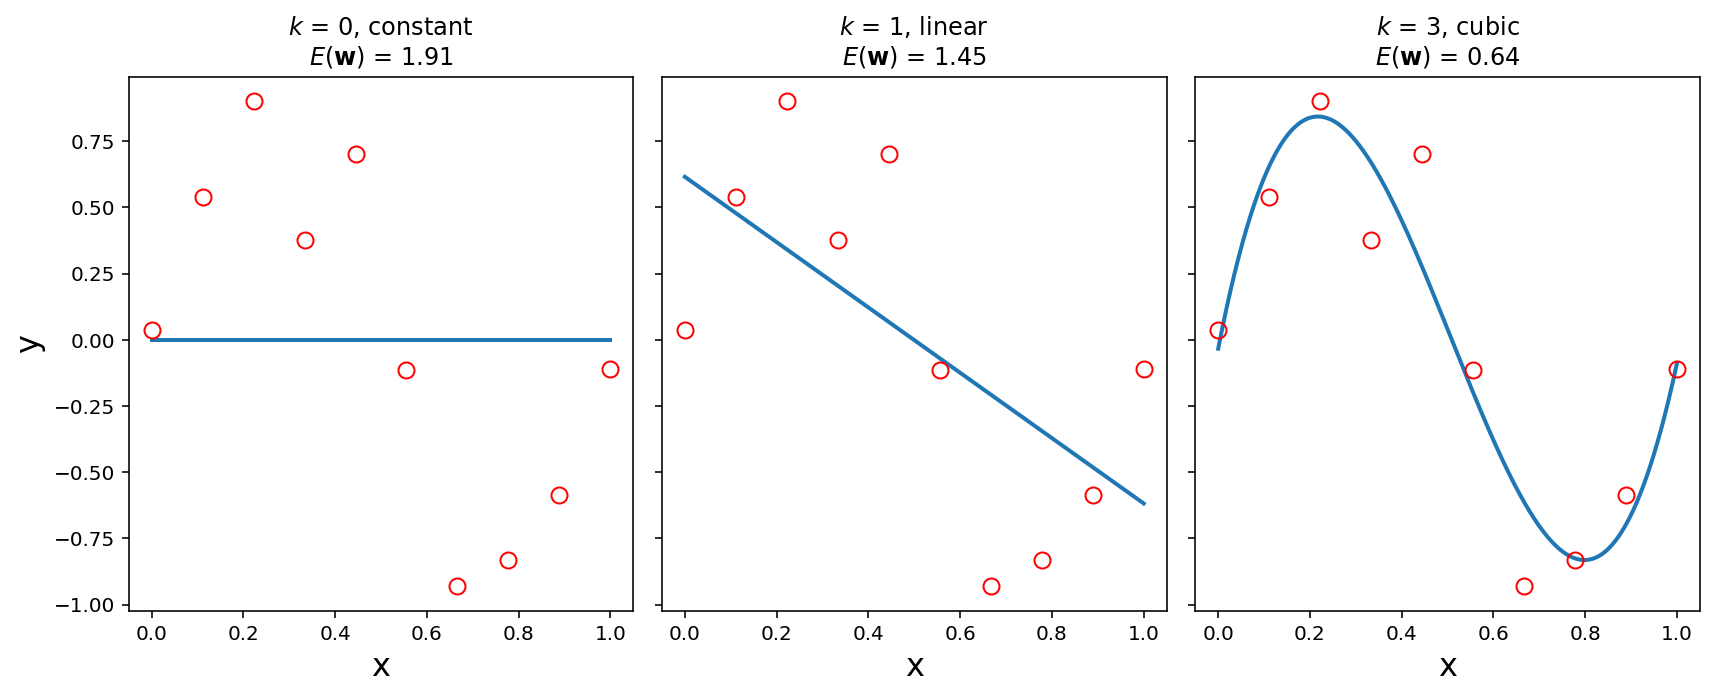

In [20]:
fig, axs = plt.subplots(1, 3, sharey = True, figsize = (12, 5))
#
cy = 1000 * [w_hat_0]
pred_y = N * [w_hat_0]
axs[0].plot(cx, cy, lw = 2, label = r'$k$ = 0')
axs[0].plot(x, y, 'ro', markersize = 8, fillstyle = 'none')
axs[0].set_xlabel('x', size = 16)
axs[0].set_ylabel('y', size = 16)
axs[0].set_title(r'$k$ = 0, constant' + '\n' + r'$E(\mathbf{w})$ =' + ' {:0.2f}'.format(np.linalg.norm(y - pred_y)))
#axs[0].legend(loc = 'best', fontsize = 16)
#
cy = design_matrix(cx, 1) @ w_hat_1
pred_y = design_matrix(x, 1) @ w_hat_1
axs[1].plot(cx, cy, lw = 2, label = r'$k$ = 1')
axs[1].plot(x, y, 'ro', markersize = 8, fillstyle = 'none')
axs[1].set_xlabel('x', size = 16)
axs[1].set_title(r'$k$ = 1, linear' + '\n' + r'$E(\mathbf{w})$ =' + ' {:0.2f}'.format(np.linalg.norm(y - pred_y)))
#axs[1].legend(loc = 'best', fontsize = 16)
#
cy = design_matrix(cx, 3) @ w_hat_3
pred_y = design_matrix(x, 3) @ w_hat_3
axs[2].plot(cx, cy, lw = 2, label = r'$k$ = 3')
axs[2].plot(x, y, 'ro', markersize = 8, fillstyle = 'none')
axs[2].set_xlabel('x', size = 16)
axs[2].set_title('$k$ = 3, cubic' + '\n' + r'$E(\mathbf{w})$ =' + ' {:0.2f}'.format(np.linalg.norm(y - pred_y)))
#axs[2].legend(loc = 'best', fontsize = 16)
#
fig.tight_layout();

So it looks like a third-order polynomial ($k$ = 3) is a good fit!

How do we know it's good?   Well, the training error $E(\mathbf{w})$ is small.

But ... can we make the training error __smaller__?

Yes, we can, if we increase the order of the polynomial.

In fact, we can reduce the error to zero!

By setting $k = 9$, we get the following polynomial fit to the data:

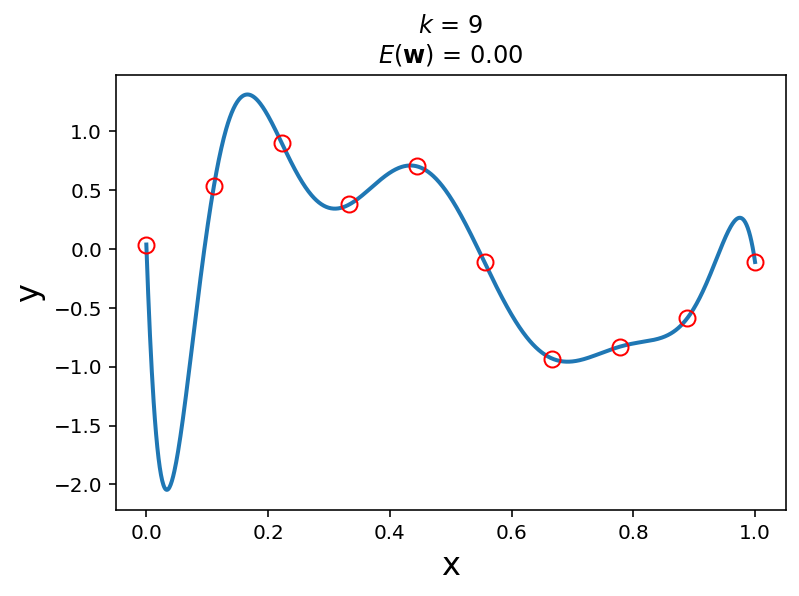

In [21]:
w_hat_9 = fit_poly(x, y, 9)
cy = design_matrix(cx, 9) @ w_hat_9
plt.plot(cx, cy, lw = 2, label = r'$k$ = 9')
plt.plot(x, y, 'ro', markersize = 8, fillstyle = 'none')
plt.xlabel('x', size = 16)
plt.ylabel('y', size = 16)
plt.title(r'$k$ = 9' + '\n' + r'$E(\mathbf{w})$ =' + ' {:0.2f}'.format(0));

So ... is the 9th order polynomial a "better" model for this dataset?

__Absolutely not!__

Why?

Informally, the model is very "wiggly".  It seems unlikely that the real data generation process is governed by this curve.

In other words, we don't expect that, if we had __more__ data from the same source, that this model would do a good job of fitting the additional data.

We want the model to do a good job of predicting on __future__ data.  This is called
the model's __generalization__ ability.   

The 9th degree polynomial would seem to have poor generalization ability.

Let's assess generalization error.   For each polynomial (value of $k$) we will use new data, called __test__ data.  This is data that was __not__ used to train the model, but comes from the same source.

In our case, we know how the data is generated -- $\sin(2\pi x)$ plus noise -- so we can easily generate more.

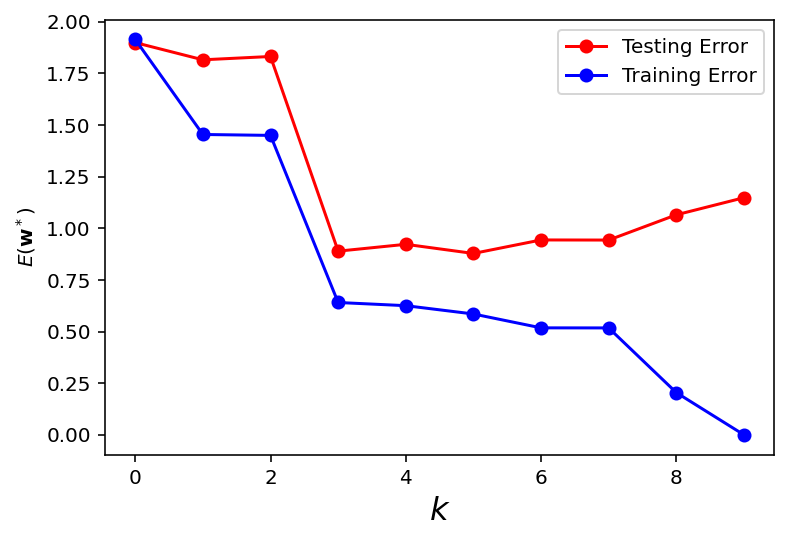

In [22]:
test_y = np.sin(2 * np.pi * x) + default_rng(8).normal(size = N, scale = 0.20)
max_k = N
train_err = [np.linalg.norm(y - N * [w_hat_0])]
test_err = [np.linalg.norm(test_y - N * [w_hat_0])]
for k in range(1, max_k):
    w_hat = fit_poly(x, y, k)
    pred_y = design_matrix(x, k) @ w_hat
    train_err.append(np.linalg.norm(y - pred_y))
    test_err.append(np.linalg.norm(test_y - pred_y))
plt.plot(range(max_k), test_err, 'ro-', label = 'Testing Error')
plt.plot(range(max_k), train_err, 'bo-', label = 'Training Error')
plt.xlabel(r'$k$', size = 16)
plt.ylabel(r'$E(\mathbf{w}^*)$')
plt.legend(loc = 'best');

Notice that as we increase the order of the polynomial, the training error always declines.

Eventually, the training error reaches zero.

However, the test error does not -- it reaches its smallest value at $k = 3$, a cubic polynomial.

The phenomenon in which training error declines, but testing error does not, is called __overfitting.__

In a sense we are fitting the training data "too well".

There are two ways to think about overfitting:

1. The number of parameters in the model is too large, compared to the size of the training data.   We can see this in the fact that we have only 10 training points, and the 9th order polynomial has 10 coefficents. 

2. The model is more complex than the actual phenomenon being modeled.  As a result, the model is not just fitting the underlying phenomenon, but also the noise in the data.

These suggest techniques we may use to avoid overfitting:

1. Increase the amount of training data.  All else being equal, more training data is always better.

2. Limit the complexity of the model.  Model complexity is often controlled via __hyperparameters__.

### More Training Data

It's not necessarily true that a order-3 polynomial is best for this problem.

After all, we are fitting to a sine function, whose Taylor series includes polynomials of all orders.

But the higher the order of polynomial we want to fit, the more data we need to avoid overfitting.

Here we use an order-9 polynomial for increasing amounts of training data (N = 15, 50, 200):

In [23]:
Ns = [15, 50, 200]
xs = {Nval: np.linspace(0, 1, Nval) for Nval in Ns}
ys = {Nval: np.sin(2 * np.pi * xs[Nval]) + default_rng(3).normal(size = Nval, scale = 0.20) for Nval in Ns}

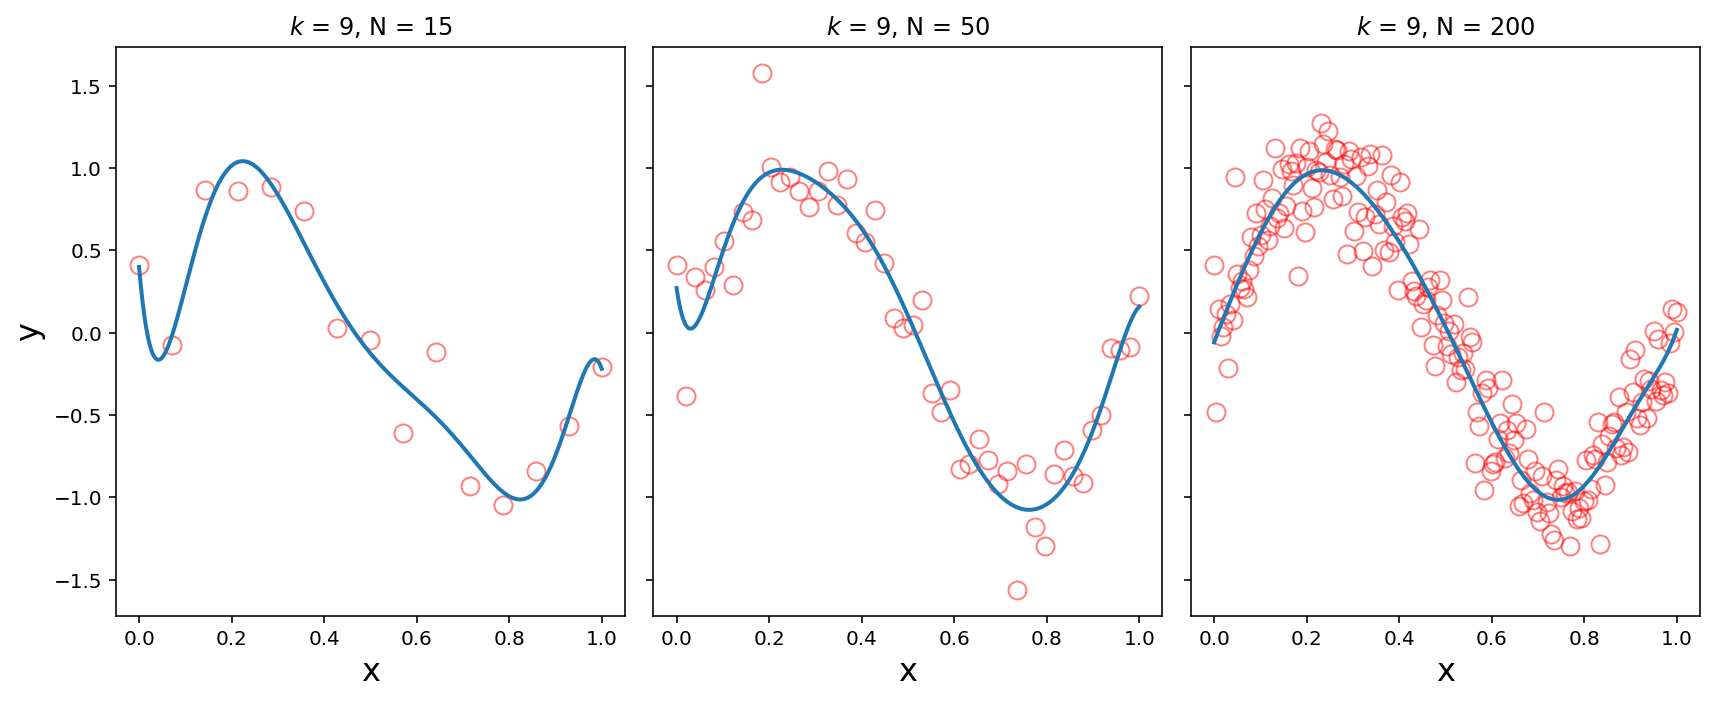

In [24]:
fig, axs = plt.subplots(1, 3, sharey = True, figsize = (12, 5))
#
cx = np.linspace(0, 1, 1000)
for i, Nval in enumerate(Ns):
    w_star = fit_poly(xs[Nval], ys[Nval], 9)
    cy = design_matrix(cx, 9) @ w_star
    pred_y = design_matrix(xs[Nval], 9) @ w_star
    axs[i].plot(xs[Nval], ys[Nval], 'ro', markersize = 9, fillstyle = 'none', alpha = 0.5)
    axs[i].plot(cx, cy, lw = 2, label = r'$N$ = {}'.format(Nval))
    axs[i].set_xlabel('x', size = 16)
    if i == 0:
        axs[i].set_ylabel('y', size = 16)
    axs[i].set_title(r'$k$ = 9, N = {}'.format(Nval))
#
fig.tight_layout();

We see that with enough training data, the high order polynomial begins to capture the sine wave well.

### Parameters and Hyperparameters

Many times however, we cannot simply get more training data, or enough training data, to solve the overfitting problem. 

In that case, we need to control the complexity of the model.

Notice that model selection problem required us to choose a value $k$ that specifies the order of the polynomial model.

As already mentioned, the values $w_0, w_1, \dots, w_k$ are called the __parameters__ of the model.

In contrast, $k$ is called a __hyperparameter.__

A hyperparameter is a parameter that must be set first, before the (regular) parameters can be learned.

Hyperparameters are often used to control model complexity.

Here, the hyperparameter $k$ controls the complexity (the order) of the polynomial model.

So, to avoid overfitting, we need to choose the proper value for the hyperparameter $k$.

We do that by __holding out data.__

### Holding Out Data

The idea behind holding out data is simple.

We want to avoid overfitting, which occurs when a model fails to generalize -- that is, when it has high error on  data that it was not trained on.

So: we will hold some data aside, and __not__ use it for training the model, but instead use it for testing generalization ability.

Let's assume that we have 20 data points to work with, stored in arrays `x` and `y`.

`scikit-learn` has some functions that can be helpful. 

We will use `train_test_split()`:

In [25]:
N = 20
x = np.linspace(0, 1, N)
y = np.sin(2 * np.pi * x) + default_rng(2).normal(size = N, scale = 0.20)

In [26]:
import sklearn.model_selection as model_selection

x_train, x_test, y_train, y_test = model_selection.train_test_split(
        x, y, test_size = 0.5, random_state = 0)

print(f'Number of items in training set: {x_train.shape[0]}, in testing set: {x_test.shape[0]}')

Number of items in training set: 10, in testing set: 10


Notice that `train_test_split()` splits the data __randomly.__

This will be important.

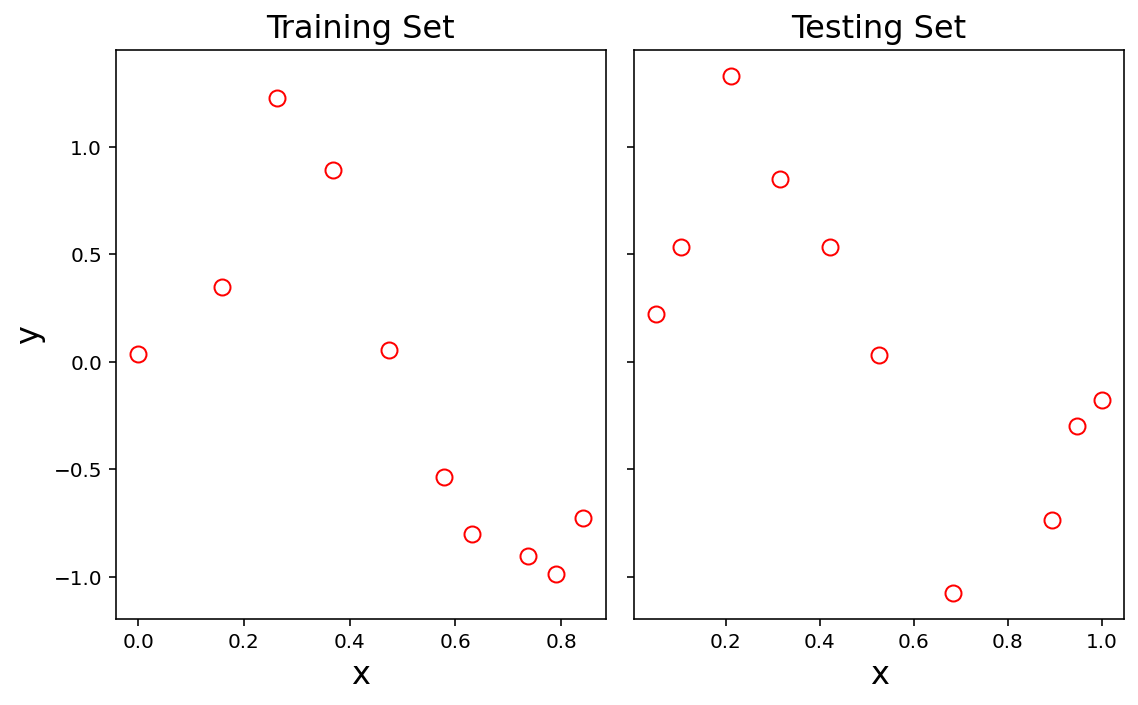

In [27]:
fig, axs = plt.subplots(1, 2, sharey = True, figsize = (8, 5))
#
axs[0].plot(x_train, y_train, 'ro', markersize = 8, fillstyle = 'none')
axs[0].set_xlabel('x', size = 16)
axs[0].set_ylabel('y', size = 16)
axs[0].set_title('Training Set', size = 16)
#
axs[1].plot(x_test, y_test, 'ro', markersize = 8, fillstyle = 'none')
axs[1].set_xlabel('x', size = 16)
axs[1].set_title('Testing Set', size = 16)
#
fig.tight_layout();

Our strategy will be:
   * For each possible value of the hyperparameter $k$:
        * randomly split the data 5 times
        * compute the mean testing and training error over the 5 random splits

What are good possible values for the hyperparameter?  It can depend on the problem, and may involve trial and error.

This strategy of trying all possible values of the hyperparameter is called a __grid search__.

In [28]:
def model_error(x_train, y_train, x_test, y_test, k):
    '''
    This function fits a polynomial of degree k to the training data
    and returns the error on both the training and test data.
    '''
    w_star = fit_poly(x_train, y_train, k)
    pred_test_y = design_matrix(x_test, k) @ w_star
    pred_train_y = design_matrix(x_train, k) @ w_star
    return (np.linalg.norm(y_train - pred_train_y), np.linalg.norm(y_test - pred_test_y))

np.random.seed(7)

In [29]:
# 
# fraction of data used for testing
#
split_frac = 0.5
#
# maximum polynomial degree to consider
#
max_k = 10
#
n_splits = 5
#
# grid search over k
# we assume a model_error() function that reports the
# training and testing error
# (definition omitted for space)
# 
#
err = []
for k in range(1, max_k):
    for s in range(n_splits):
        x_train, x_test, y_train, y_test = model_selection.train_test_split(
            x, y, test_size = 0.5)
        split_train_err, split_test_err = model_error(x_train, y_train, x_test, y_test, k)
        err.append([k, s, split_train_err, split_test_err])
#
# put the results in a DataFame for easy manipulation
#
df = pd.DataFrame(err, columns = ['k', 'split', 'Training Error', 'Testing Error'])
df.head(10)

,k,split,Training Error,Testing Error
0,1,0,1.147829,2.799292
1,1,1,1.700576,1.712716
2,1,2,1.387723,2.133381
3,1,3,1.696808,1.695534
4,1,4,1.571746,1.989020
5,2,0,1.358846,2.603490
6,2,1,1.332199,2.082828
7,2,2,0.747769,5.436927
8,2,3,1.559011,2.697498
9,2,4,1.677090,1.691438


Let's plot the mean for each value of `k` and its standard error ($\sigma/\sqrt{n}$):

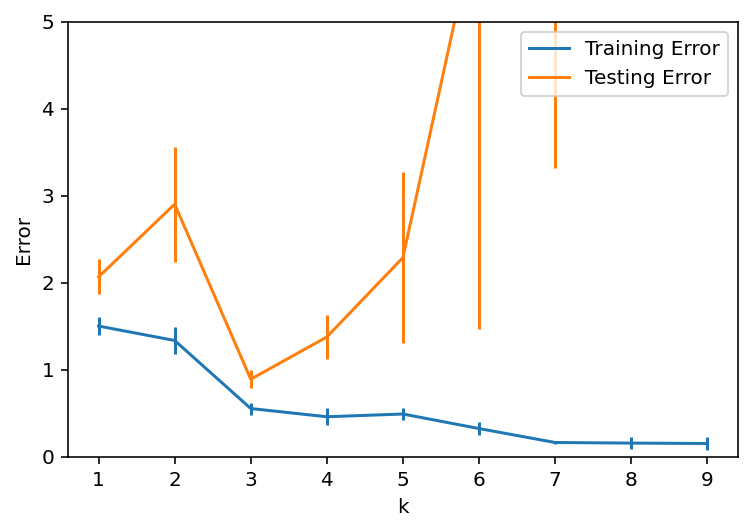

In [30]:
df.groupby('k').mean()[['Training Error', 'Testing Error']].plot(
    yerr = df.groupby('k').std()/np.sqrt(n_splits))
plt.ylabel('Error')
plt.ylim([0, 5]);

From this plot we can conclude that, for this dataset, a polynomial of degree $k = 3$ shows the best generalization ability.

### Hold Out Strategies

Deciding how much, and which, data to hold out depends on a number of factors.

In general we'd like to give the training stage as much data as possible to work with.

However, the more data we use for training, the less we have for testing -- which can decrease the accuracy of the testing stage.

Furthermore, any single partition of the data can introduce dependencies -- any class that is overrepresented in the training data will be underrepresented in the test data.

There are two ways to address these problems:
* Random subsampling
* Cross-validation

In __random subsampling__ one partitions the data randomly between train and test sets.  This is what the function `train_test_split()` does.

This ensures there is no dependence between the test and train sets.

One needs to perform a reasonable number of random splits - usually five at least.

In __cross-validation__, the data is partitioned once, and then each partition is used as the test data once.

This ensures that all the data gets equal weight in the training and in the testing.

We divide the data into $k$ "folds".

<center>
    
<img src="figs/L13-k-fold.png" alt="Figure" width="50%">
    
</center>  

The value of $k$ can vary up to the size of the dataset.

The larger $k$ we use, the more data is used for training, but the more folds must be evaluated, which increases the time required.

In the extreme case where $k$ is equal to the data size, then each data item is held out by itself; this is called "leave-one-out".

## Conclusions

We have seen strategies that allow us to learn from data.

The strategies include:
   * Define a set of possible models
   * Define an error function that tells us when the model is predicting well
   * Using the error function, search through the space of models to find the best performer

We've also seen that there are some subtleties to this approach that must be dealt with to avoid problems:
   * Simply using the model that has lowest error on the training data will __overfit__.
   * We need to __hold out__ data to assess the generalization ability of each trained model.
   * We control model complexity using hyperparameters
   * We choose the best hyperparameters based on performance on held out data.